In [1]:
import sys
sys.path.append('../')

import numpy as np
#from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
#from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import ResNet50

from tensorflow.nn import depthwise_conv2d, relu
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

2025-10-08 12:50:42.530511: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 12:50:42.542465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759942242.556780   16589 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759942242.561236   16589 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759942242.572174   16589 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

#### Experiment #1 : Confirming that most energy lies within the first 3 DCT coeficients

In [2]:
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

2025-10-08 12:50:45.311725: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-10-08 12:50:45.311743: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-10-08 12:50:45.311747: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: tech-Alienware-m15-R6
2025-10-08 12:50:45.311749: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: tech-Alienware-m15-R6
2025-10-08 12:50:45.311842: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 535.230.2
2025-10-08 12:50:45.311852: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)


In [4]:
len(conv_layers)

16

/tmp/ipykernel_16589/3714160788.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_16589/3714160788.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_16589/3714160788.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_16589/3714160788.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[l_num].set_xticklabels([''] * ws.shape[0])  # Set empty labels
/tmp/ipykernel_16589/3714160788.py:77: UserWarning: set_

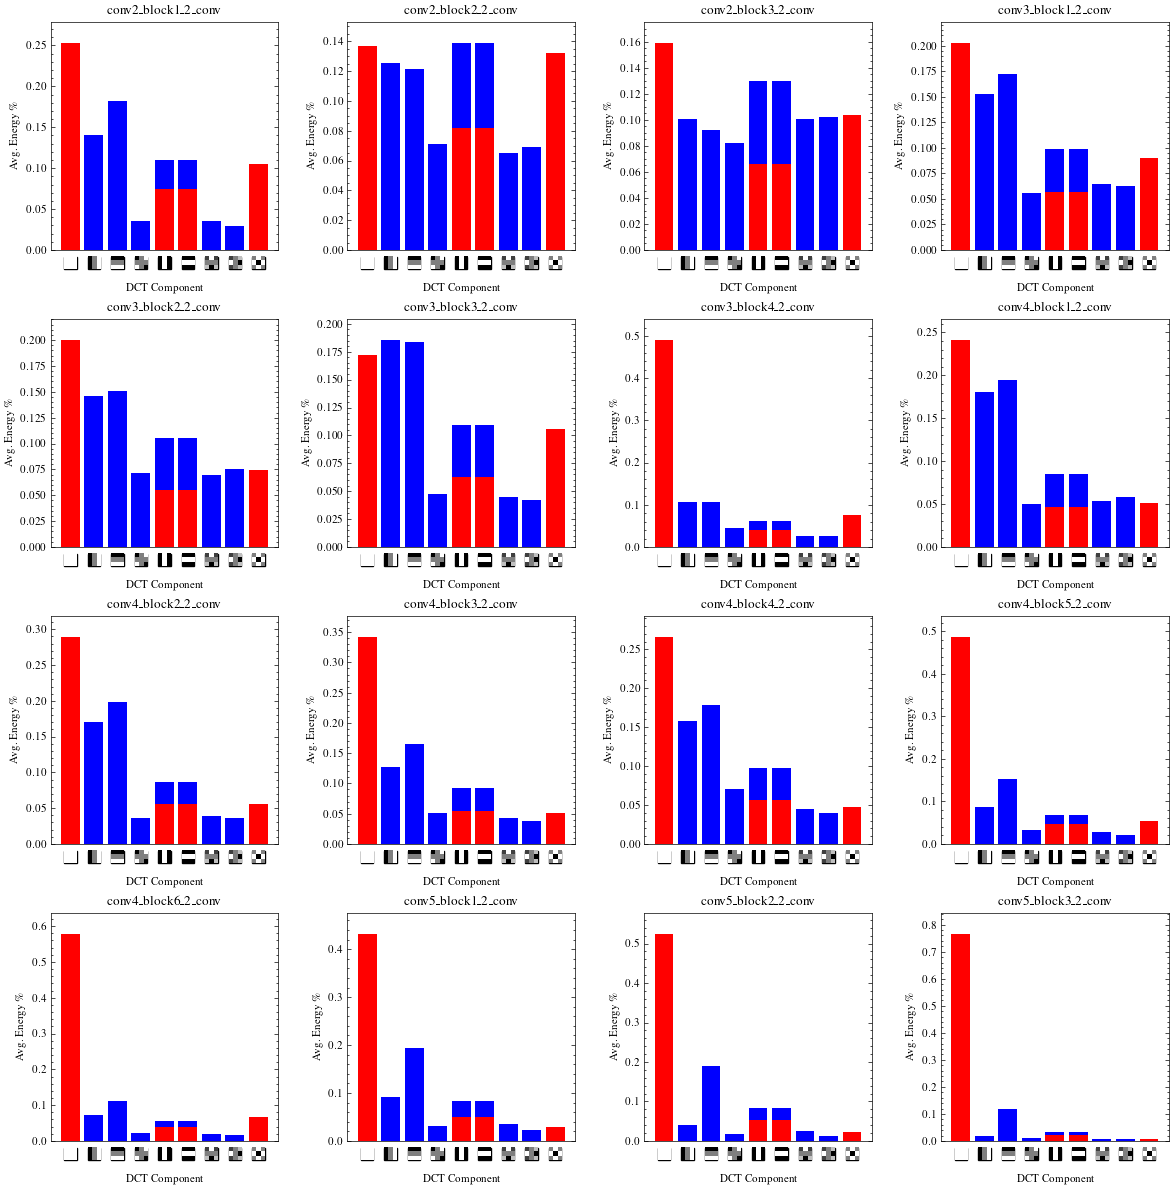

In [5]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


#bars =  ax.bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], vals)
pos = [(0,0) , (0,1), (1,0), (1,1), (0, 2) , (2, 0), (1,2), (2,1), (2,2) ]

d = []
for  i,j in pos:
	t = np.zeros((3,3))
	t[i,j] =1
	d.append(tf.reshape(fft.idctn(t, norm='ortho'), (3,3,1,1)))
d = tf.cast(tf.stack(d), dtype=tf.float64)

fig,axs= plt.subplots(nrows=4, ncols=4,figsize=(12, 12))
axs = axs.ravel()

for l_num in range(0, 16):
	if l_num == -1:
		f = np.random.normal(0,1, size=(3,3,100,100)).astype('float64')
		title = "Random"
	else:
		f = get_filter(model, l_num)
		title = conv_layers[l_num].name

	f = tf.cast(f, dtype=tf.float64)

	s, a = getSymAntiSymTF(f)

	# Plot Symmetric part of filters
	ws = tf.reshape(tf.reduce_sum(s.numpy()*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
	#print( tf.reduce_sum(tf.abs(ws), axis=(1,2,3,4))/tf.math.reduce_sum(tf.abs(f)))
	bars =  axs[l_num].bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], tf.reduce_sum(ws**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2), color = "r", label = r"Sym Energy")
	
	# Plot AntiSymmetric part of filters
	wa = tf.reshape(tf.reduce_sum(a.numpy()*d, axis=(1,2)), (d.shape[0],1,1, f.shape[-2], f.shape[-1]))
	bars =  axs[l_num].bar(["dc", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"], 
						  tf.reduce_sum(wa**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2), 
						  color = "b", label=r"Anti Energy",
						  bottom=tf.reduce_sum(ws**2, axis=(1,2,3,4))/tf.math.reduce_sum(f**2))

	if l_num == -1:
		legend = axs[l_num].legend(
			loc='lower right',
			prop={'size': 11},
			frameon=True  # make sure the frame is drawn
		)
		frame = legend.get_frame()
		frame.set_facecolor('white')   # solid white background
		frame.set_edgecolor('black')   # black border (optional)
		frame.set_linewidth(0.8)
		frame.set_alpha(1.0)           # fully opaque

	for i, bar in enumerate(bars):
		# Load image

		dct_im = np.zeros((3,3))
		dct_im[pos[i]]=1
		#print(idct2(np.float16(dct_im)))
		img = idct2(np.float16(dct_im))

		# Create OffsetImage object
		im = OffsetImage(img, zoom=3, cmap=plt.cm.binary)  # Adjust zoom for image size

		# Get the x position of the bar's center
		x_position = bar.get_x() + bar.get_width() / 2

		# Place image below the x-axis label
		ab = AnnotationBbox(im, (x_position, 0), 
							xybox=(0, -5),  # Adjust the second value for distance under the label
							xycoords='data', 
							boxcoords="offset points", 
							pad=0, frameon=True, 
							box_alignment=(0.5, 1))

		# Add image to the axes
		axs[l_num].add_artist(ab)
	axs[l_num].set_xticklabels([''] * ws.shape[0])  # Set empty labels
	axs[l_num].set_xlabel('DCT Component')
	axs[l_num].xaxis.set_label_coords(0.5, -0.15)
	axs[l_num].set_ylabel('Avg. Energy \%')

	sym  = (tf.reduce_sum(ws**2, axis=(1,2,3,4)) / tf.reduce_sum(f**2)).numpy()
	anti = (tf.reduce_sum(wa**2, axis=(1,2,3,4)) / tf.reduce_sum(f**2)).numpy()
	stack = sym + anti
	axs[l_num].set_ylim(0, 1.10 * float(stack.max()))  # a little headroom
	axs[l_num].set_box_aspect(1)
	axs[l_num].set_title(title)


	axs[l_num].tick_params(axis='x', which='both', length=0)
axs[-1].set_box_aspect(1)

#fig.delaxes(axs[-1])

fig.tight_layout()
plt.savefig('resnet_dct.pdf', dpi=600)

plt.show()